# Download packages

In [1]:
!pip install git+https://github.com/qubvel/classification_models.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-91f6nk1f
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-91f6nk1f
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20048 sha256=3c3754fa2683e390b04510b5e3f34d6a39de3550cff1e2b0d05130ec135a7c02
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0r8vlvv/wheels/e7/c3/c8/78c1f9edf72d00198ac018396707125272de9c1abdd99a4043
Successfully built image-classifiers


In [2]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.8 MB/s eta 0:00:00


# Initialisation and data cleaning

In [3]:
# Import resnet lib
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD, Nadam
import time
from classification_models.keras import Classifiers
import tensorflow_addons as tfa
from keras import backend as K

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
import subprocess
print(subprocess.getoutput('nvidia-smi'))

Sun Apr 23 21:05:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

170498071/170498071 [==============================] - 5s 0us/step


# Build Tiny ResNet and padam

In [6]:
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
    residual = x

    if conv_shortcut:
        residual = Conv2D(filters, 1, strides=stride, padding='same', name=name+'_shortcut')(x)
        residual = BatchNormalization(name=name+'_shortcut_bn')(residual)

    x = BatchNormalization(name=name+'_bn1')(x)
    x = Activation('relu', name=name+'_relu1')(x)
    x = Conv2D(filters, kernel_size, padding='same', name=name+'_conv1')(x)

    x = BatchNormalization(name=name+'_bn2')(x)
    x = Activation('relu', name=name+'_relu2')(x)
    x = Conv2D(filters, kernel_size, strides=stride, padding='same', name=name+'_conv2')(x)

    x = Add(name=name+'_add')([x, residual])
    return x


In [7]:
# Create a tiny resnet to demand the limited computing performance
def create_tiny_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, 3, padding='same', activation='relu', name='conv1')(inputs)

    # Only 2 residual blocks instead of 3 for each stage
    x = resnet_block(x, 16, name='block1_0')
    x = resnet_block(x, 16, name='block1_1')

    x = resnet_block(x, 32, stride=2, name='block2_0')
    x = resnet_block(x, 32, name='block2_1')

    x = resnet_block(x, 64, stride=2, name='block3_0')
    x = resnet_block(x, 64, name='block3_1')

    x = BatchNormalization(name='bn')(x)
    x = Activation('relu', name='relu')(x)
    x = Flatten(name='flatten')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
class Padam(tfa.optimizers.RectifiedAdam):
    def __init__(self, p=0.5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p
        
    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_dtype = var.dtype.base_dtype
        local_step = tf.cast(self.iterations + 1, var_dtype)
        beta_1_t = tf.cast(self._get_hyper('beta_1', var_dtype), var_dtype)
        beta_2_t = tf.cast(self._get_hyper('beta_2', var_dtype), var_dtype)
        one_minus_beta_1_t = 1 - beta_1_t
        one_minus_beta_2_t = 1 - beta_2_t
        
        step_size = self._get_hyper('learning_rate', var_dtype) * (tf.sqrt(1 - tf.pow(beta_2_t, local_step)) / (1 - tf.pow(beta_1_t, local_step)))

        m = self.get_slot(var, 'm')
        m_t = (m * beta_1_t) + (grad * one_minus_beta_1_t)
        m_hat_t = m_t / (1 - tf.pow(beta_1_t, local_step))
        
        v = self.get_slot(var, 'v')
        v_t = (v * beta_2_t) + (tf.square(grad) * one_minus_beta_2_t)
        v_hat_t = v_t / (1 - tf.pow(beta_2_t, local_step))
        
        denom = tf.pow(tf.sqrt(v_hat_t) + K.epsilon(), self.p)
        var_t = var - step_size * (m_hat_t / denom)
        
        return tf.compat.v1.assign(var, var_t)

# Train Model

In [9]:
# This function use Resnet 50 architecture
def train_model_with_optimizer(optimizer, batch_size, epochs):
    input_shape = (32, 32, 3)
    num_classes = 10
    model = create_tiny_resnet(input_shape, num_classes)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])
    start_time = time.time()
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), verbose=0)
    end_time = time.time()
    training_time = end_time - start_time
    return history, training_time, model

In [10]:
# 200 epochs (Same as the paper)
# Need to re-complie the model if ran 50 epochs before
optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'SGD': SGD(learning_rate=0.001, momentum=0.9),
    'Nadam': Nadam(learning_rate=0.001),
    'Adam_Amsgrad': Adam(learning_rate=0.001, amsgrad=True), 
    'Padam': Padam(learning_rate=0.1, total_steps=10000, p=0.125, beta_1=0.9, beta_2=0.999, weight_decay=5e-4)
}

histories_200epochs = {}
training_times_200epochs = {}
models = {}

for name, optimizer in optimizers.items():
    print(f"Training with {name} optimizer...")
    histories_200epochs[name], training_times_200epochs[name], models[name] = train_model_with_optimizer(optimizer, 128, 100)

for name, model in models.items():
    model.save(f'./Model/resnet_model_{name}.h5')

Training with Adam optimizer...
Training with SGD optimizer...
Training with Nadam optimizer...
Training with Adam_Amsgrad optimizer...
Training with Padam optimizer...


# Plot figure without padam

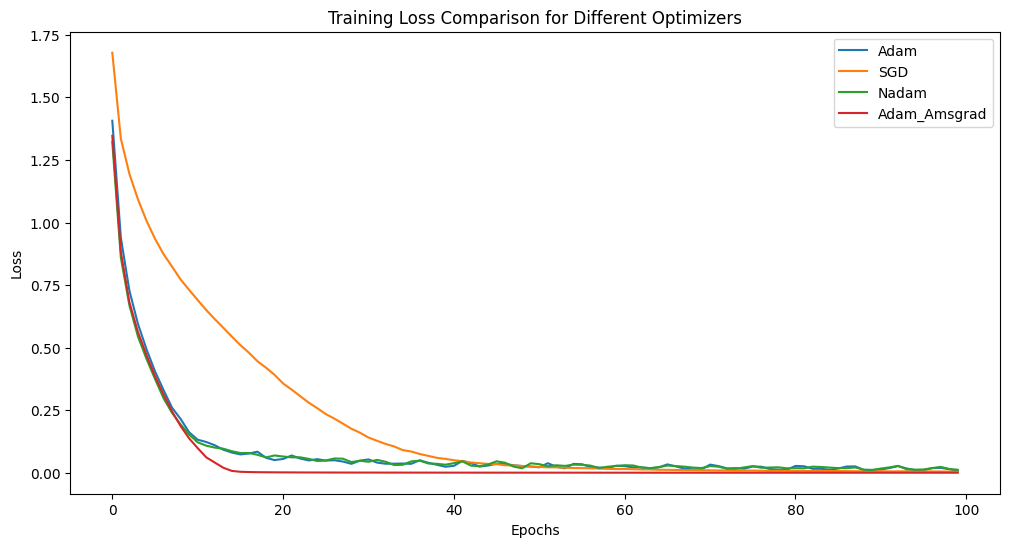

In [11]:
plt.figure(figsize=(12, 6))

for name, history in histories_200epochs.items():
  if name != 'Padam':
    plt.plot(history.history['loss'], label=f"{name}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison for Different Optimizers')
# Save the figure before displaying it
plt.savefig('./Results/Train_Loss_nopadam.png', dpi=300, bbox_inches='tight')
plt.show()

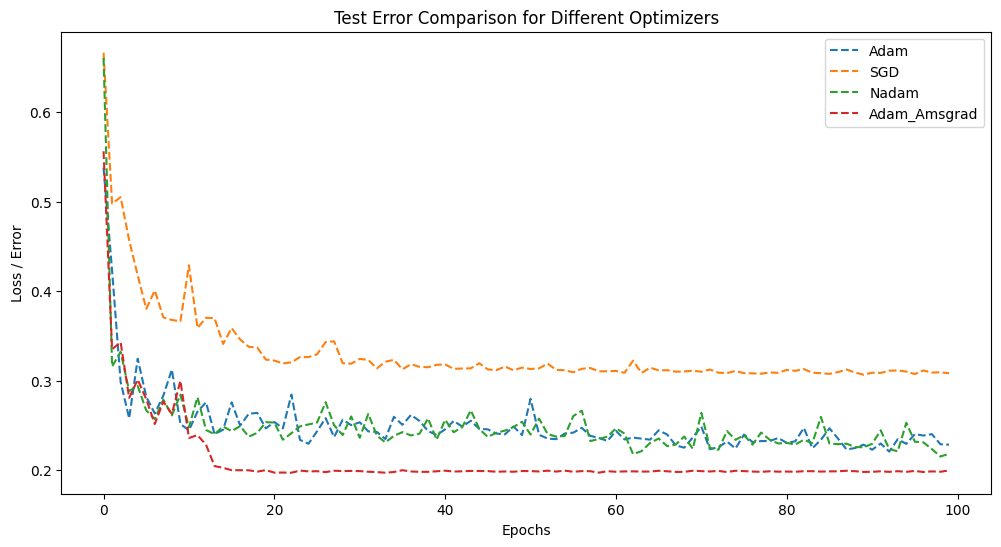

In [12]:
plt.figure(figsize=(12, 6))

for name, history in histories_200epochs.items():
  if name != 'Padam':
    test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
    plt.plot(test_error, label=f"{name}", linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss / Error')
plt.legend()
plt.title('Test Error Comparison for Different Optimizers')
# Save the figure before displaying it
plt.savefig('./Results/Test_Error_nopadam.png', dpi=300, bbox_inches='tight')
plt.show()

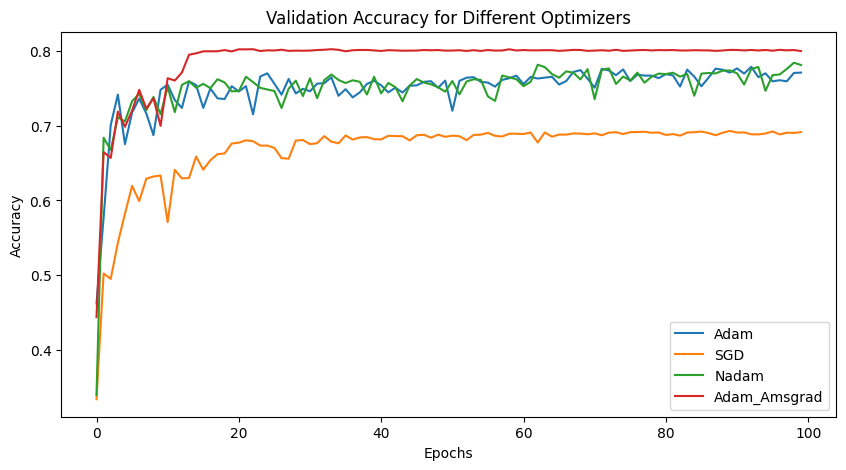

In [13]:
plt.figure(figsize=(10, 5))
for name, history in histories_200epochs.items():
  if name != 'Padam':
    plt.plot(history.history['val_accuracy'], label=f"{name}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy for Different Optimizers')
plt.savefig('./Results/validation_accuracy_nopadam.png', dpi=300, bbox_inches='tight')
plt.show()

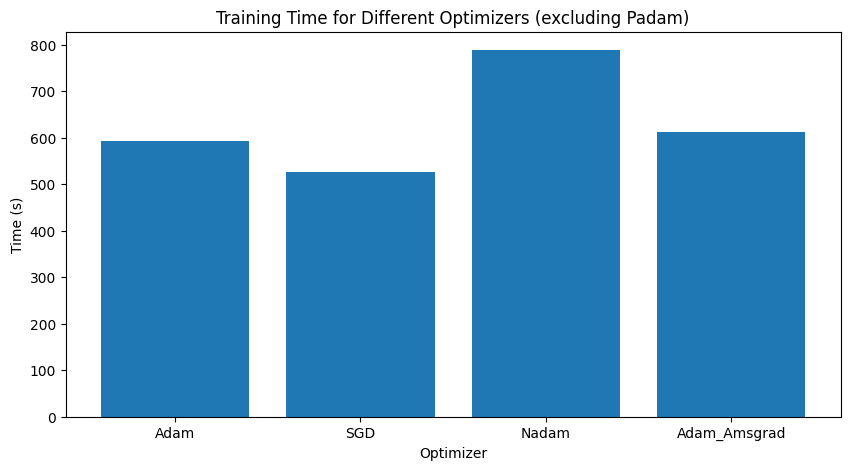

In [14]:
plt.figure(figsize=(10, 5))

# Exclude the 'Padam' optimizer
filtered_optimizers = {k: v for k, v in training_times_200epochs.items() if k != 'Padam'}

plt.bar(filtered_optimizers.keys(), filtered_optimizers.values())
plt.xlabel('Optimizer')
plt.ylabel('Time (s)')
plt.title('Training Time for Different Optimizers (excluding Padam)')

plt.savefig('./Results/training_time_nopadam.png', dpi=300, bbox_inches='tight')
plt.show()

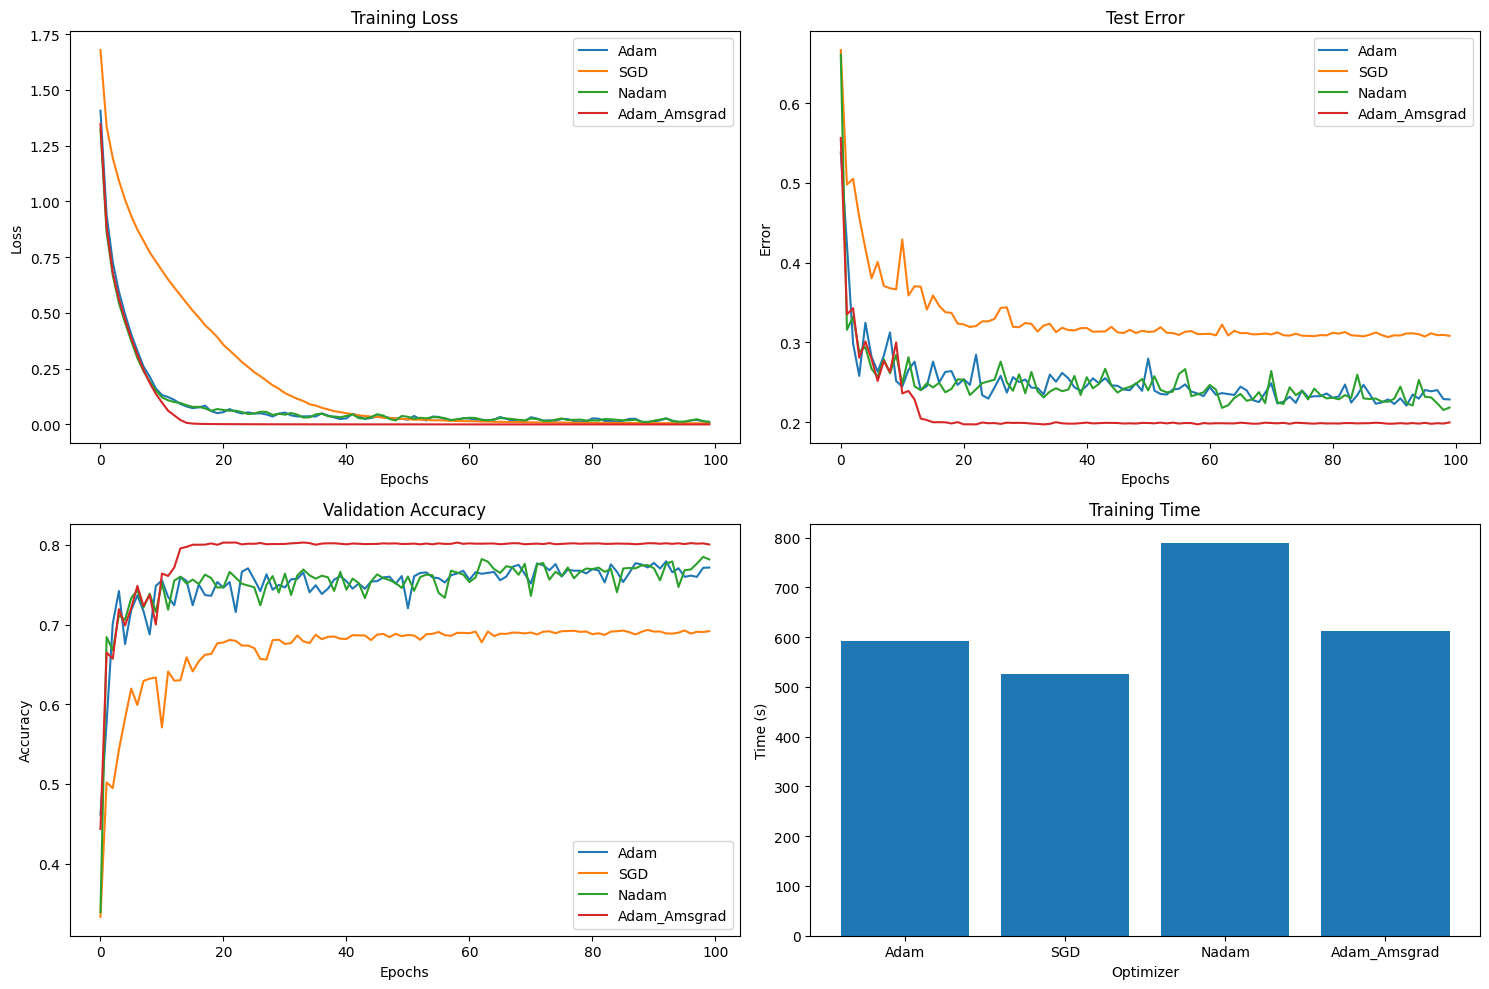

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
for name, history in histories_200epochs.items():
  if name != 'Padam':
    axes[0, 0].plot(history.history['loss'], label=f"{name}")
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training Loss')

# Test Error
for name, history in histories_200epochs.items():
  if name != 'Padam':
    test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
    axes[0, 1].plot(test_error, label=f"{name}")
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Error')
axes[0, 1].legend()
axes[0, 1].set_title('Test Error')

# Validation Accuracy
for name, history in histories_200epochs.items():
  if name != 'Padam':
    axes[1, 0].plot(history.history['val_accuracy'], label=f"{name}")
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Validation Accuracy')

# Training Time
filtered_optimizers = {k: v for k, v in training_times_200epochs.items() if k != 'Padam'}
axes[1, 1].bar(filtered_optimizers.keys(), filtered_optimizers.values())
axes[1, 1].set_xlabel('Optimizer')
axes[1, 1].set_ylabel('Time (s)')
axes[1, 1].set_title('Training Time')

plt.tight_layout()
plt.savefig('./Results/matrix_nopadam.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot figure with padam

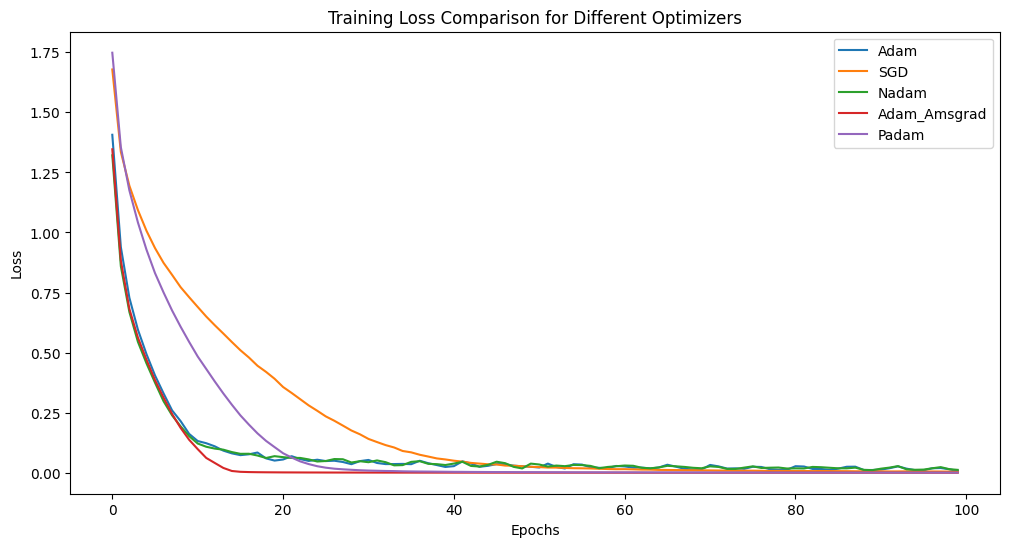

In [16]:
plt.figure(figsize=(12, 6))

for name, history in histories_200epochs.items():
    plt.plot(history.history['loss'], label=f"{name}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison for Different Optimizers')
# Save the figure before displaying it
plt.savefig('./Results/Train_Loss.png', dpi=300, bbox_inches='tight')
plt.show()

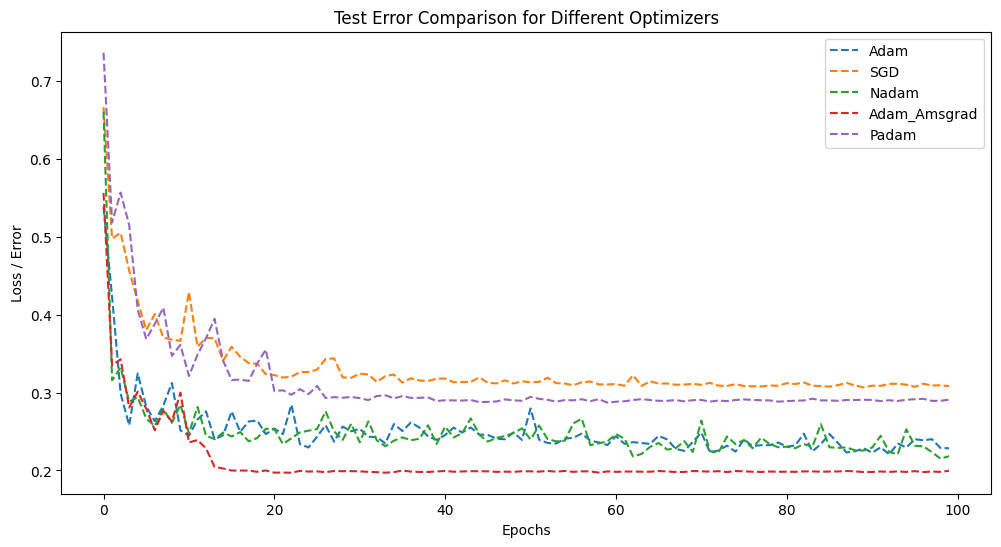

In [17]:
plt.figure(figsize=(12, 6))

for name, history in histories_200epochs.items():
    # plt.plot(history.history['loss'], label=f"{name} Training Loss")
    test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
    plt.plot(test_error, label=f"{name}", linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss / Error')
plt.legend()
plt.title('Test Error Comparison for Different Optimizers')
# Save the figure before displaying it
plt.savefig('./Results/Test_Error.png', dpi=300, bbox_inches='tight')
plt.show()

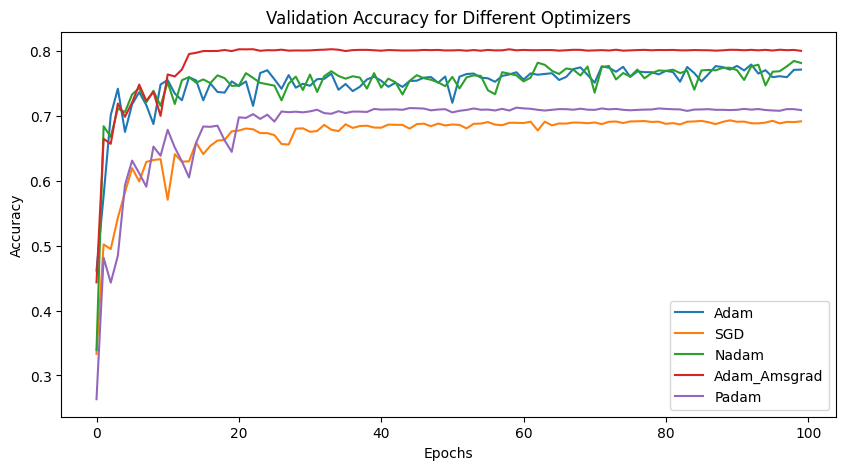

In [18]:
plt.figure(figsize=(10, 5))
for name, history in histories_200epochs.items():
    plt.plot(history.history['val_accuracy'], label=f"{name}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy for Different Optimizers')
plt.savefig('./Results/validation_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

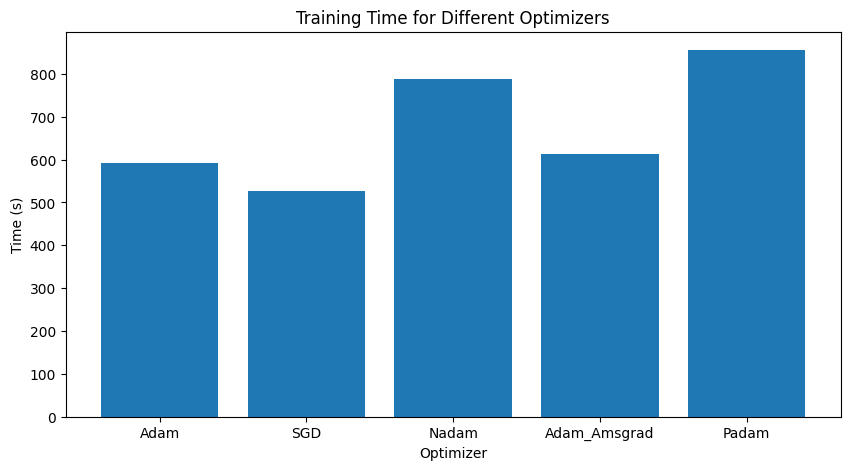

In [19]:
plt.figure(figsize=(10, 5))
plt.bar(training_times_200epochs.keys(), training_times_200epochs.values())
plt.xlabel('Optimizer')
plt.ylabel('Time (s)')
plt.title('Training Time for Different Optimizers')
plt.savefig('./Results/training_time.png', dpi=300, bbox_inches='tight')
plt.show()

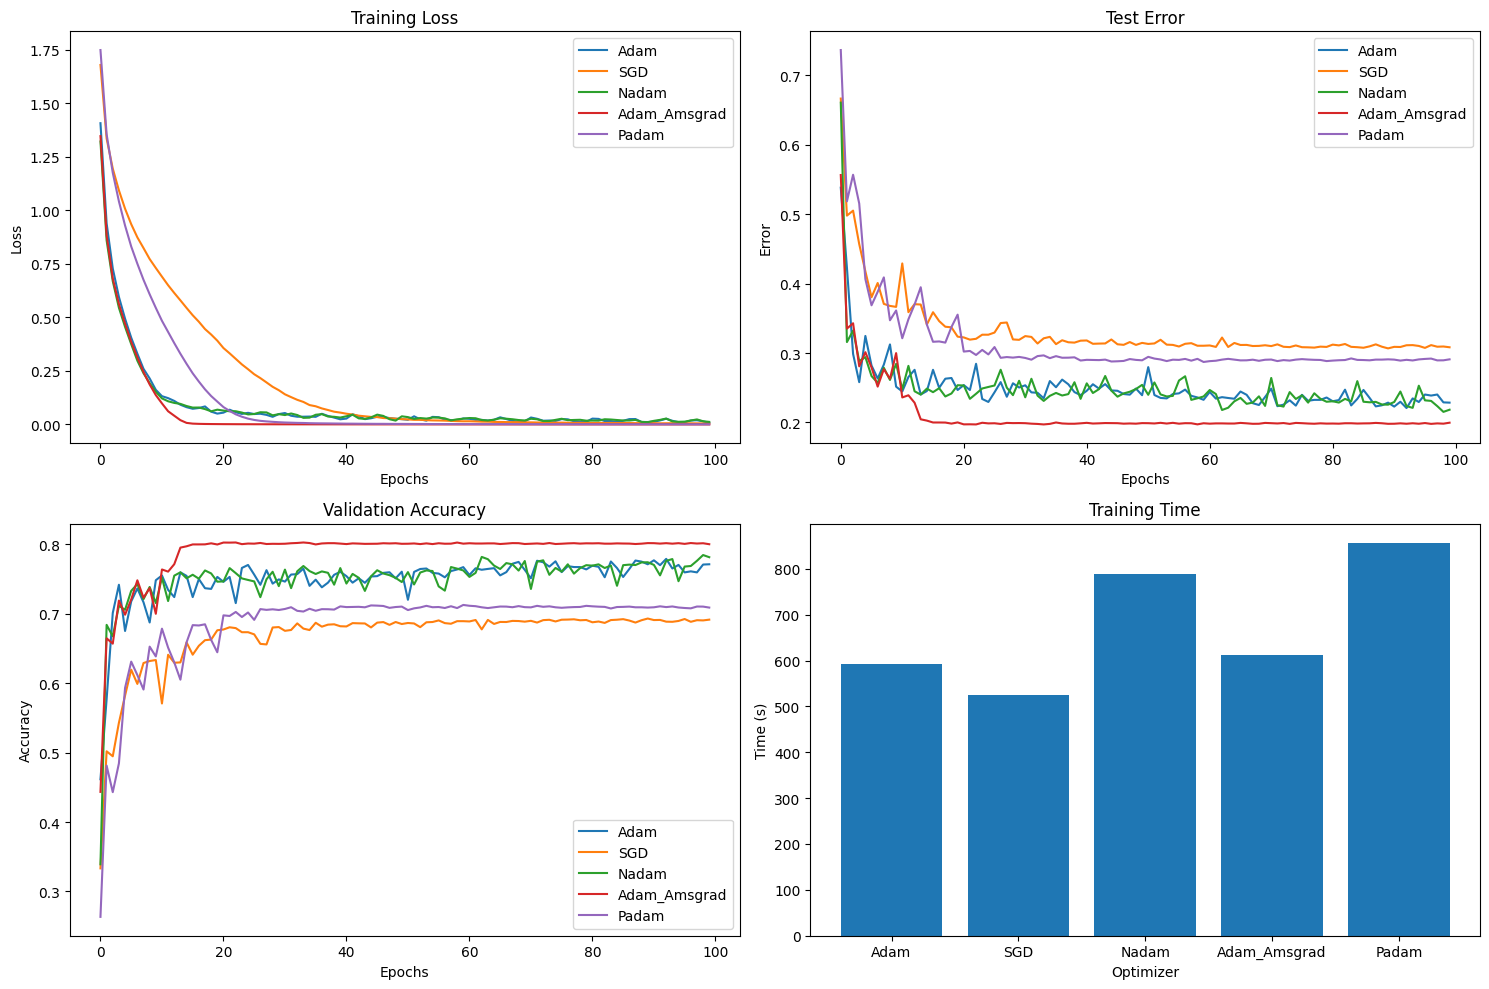

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
for name, history in histories_200epochs.items():
    axes[0, 0].plot(history.history['loss'], label=f"{name}")
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].set_title('Training Loss')

# Test Error
for name, history in histories_200epochs.items():
    test_error = [1 - accuracy for accuracy in history.history['val_accuracy']]
    axes[0, 1].plot(test_error, label=f"{name}")
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Error')
axes[0, 1].legend()
axes[0, 1].set_title('Test Error')

# Validation Accuracy
for name, history in histories_200epochs.items():
    axes[1, 0].plot(history.history['val_accuracy'], label=f"{name}")
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].set_title('Validation Accuracy')

# Training Time
axes[1, 1].bar(training_times_200epochs.keys(), training_times_200epochs.values())
axes[1, 1].set_xlabel('Optimizer')
axes[1, 1].set_ylabel('Time (s)')
axes[1, 1].set_title('Training Time')

plt.tight_layout()
plt.savefig('./Results/matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
!zip -r Model.zip ./Model
!zip -r Result.zip ./Results
!cp Model.zip /content/drive/MyDrive/TinyResNet/
!cp Result.zip /content/drive/MyDrive/TinyResNet/

  adding: Model/ (stored 0%)
  adding: Model/resnet_model_SGD.h5 (deflated 19%)
  adding: Model/resnet_model_Nadam.h5 (deflated 18%)
  adding: Model/resnet_model_Padam.h5 (deflated 72%)
  adding: Model/resnet_model_Adam_Amsgrad.h5 (deflated 17%)
  adding: Model/resnet_model_Adam.h5 (deflated 18%)
  adding: Results/ (stored 0%)
  adding: Results/training_time_nopadam.png (deflated 27%)
  adding: Results/Train_Loss.png (deflated 14%)
  adding: Results/training_time.png (deflated 30%)
  adding: Results/Test_Error_nopadam.png (deflated 9%)
  adding: Results/Train_Loss_nopadam.png (deflated 15%)
  adding: Results/validation_accuracy_nopadam.png (deflated 9%)
  adding: Results/matrix_nopadam.png (deflated 12%)
  adding: Results/validation_accuracy.png (deflated 8%)
  adding: Results/matrix.png (deflated 11%)
  adding: Results/Test_Error.png (deflated 9%)
